In [7]:
with open('abstract.txt', 'r') as f:
    ds = f.read()

In [8]:
print(ds)

To face the global sustainability issues arising from rapid industry
development and population increase, many efforts have been made to develop new
materials and technologies toward renewable energy and environmental improvement.
Zeolites are a family of crystalline materials with orderly distributed micropores
in molecular dimensions. As the most important solid catalysts used in traditional
petrochemical industries, zeolites are also finding promising applications in many
sustainable processes given their unique shape selectivity, adsorption and ion-exchange
capability, high hydrothermal stability, tunable acidity and polarity, and low production costs.
In this review, we present the state-of-the-art applications of zeolites as potential solutions
to the sustainability issues, including biomass conversion, fuel cells, thermal energy storage,
CO2 capture and conversion, air-pollution remediation, and water purification, etc.
This review highlights recent developments in the synthesis

In [78]:
# Step 1: Read the whole file
with open('abstract.txt', 'r') as f:
    text = f.read()

# Step 2: Split into paragraphs (or sentences, if preferred)
paragraphs = [p.strip() for p in text.split('\n') if p.strip()]  # Non-empty lines
print(paragraphs)
# Step 3: Save in the right format: One example per line
with open("formatted_abstract.txt", "w") as f:
    for para in paragraphs:
        f.write(para + "\n")


['To face the global sustainability issues arising from rapid industry', 'development and population increase, many efforts have been made to develop new', 'materials and technologies toward renewable energy and environmental improvement.', 'Zeolites are a family of crystalline materials with orderly distributed micropores', 'in molecular dimensions. As the most important solid catalysts used in traditional', 'petrochemical industries, zeolites are also finding promising applications in many', 'sustainable processes given their unique shape selectivity, adsorption and ion-exchange', 'capability, high hydrothermal stability, tunable acidity and polarity, and low production costs.', 'In this review, we present the state-of-the-art applications of zeolites as potential solutions', 'to the sustainability issues, including biomass conversion, fuel cells, thermal energy storage,', 'CO2 capture and conversion, air-pollution remediation, and water purification, etc.', 'This review highlights r

In [16]:
from datasets import Dataset

# Re-use your earlier code to read and split text
with open('abstract.txt', 'r') as f:
    text = f.read()

paragraphs = [p.strip() for p in text.split('\n') if p.strip()]

# Create Hugging Face dataset from list
dataset = Dataset.from_dict({"text": paragraphs})
print(dataset)
ds=dataset

Dataset({
    features: ['text'],
    num_rows: 140
})


In [ ]:
#tokenize the data

In [19]:
import os
import numpy as np
from tqdm.auto import tqdm
import tiktoken

enc = tiktoken.get_encoding("gpt2")

def process(example):
    ids = enc.encode_ordinary(example['text'])
    return {'ids': ids, 'len': len(ids)}

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the dataset",
        num_proc=8,
    )

    arr_len = np.sum(tokenized['len'], dtype=np.uint64)
    filename = 'train.bin'
    dtype = np.uint16

    arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
    total_batches = 1024

    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
        batch = tokenized.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('python')
        arr_batch = np.concatenate(batch['ids'])
        arr[idx : idx + len(arr_batch)] = arr_batch
        idx += len(arr_batch)

    arr.flush()


In [21]:
def get_batch(split):

    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('validation.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [23]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [47]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch("train")  # only use train split
            with ctx:
                logits, loss = model(X, Y)
            losses[k] = loss.item()
        out['train'] = losses.mean()
    model.train()
    return out


In [88]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 10000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 2
batch_size = 6
block_size = 128

gradient_accumulation_steps = 32

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'


dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [89]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

<ipython-input-89-8b14655fd386>:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [ ]:
#pretraing the small language model

In [90]:
best_train_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list = []

# Move model to the correct device
model = model.to(device)

# Learning rate scheduler setup
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_iters)

# Estimate loss on train only
def estimate_loss(model):
    model.eval()
    losses = torch.zeros(eval_iters)
    with torch.inference_mode():
        for k in range(eval_iters):
            X, Y = get_batch("train")
            X, Y = X.to(device), Y.to(device)
            with ctx:
                _, loss = model(X, Y)
            losses[k] = loss.item()
    model.train()
    return {"train": losses.mean()}

# Training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        train_loss = losses["train"]

        print(f"Epoch {epoch}: train loss {train_loss:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.5f}")

        train_loss_list.append(train_loss)

        if train_loss < best_train_loss:
            best_train_loss = train_loss
            torch.save(model.state_dict(), best_model_params_path)

    # Get batch and move to device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    # Perform optimizer step after accumulation
    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    scheduler.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Epoch 5000: train loss 0.0568
Learning rate: 0.00002
Epoch 5002: train loss 0.0568
Learning rate: 0.00002
Epoch 5004: train loss 0.0568
Learning rate: 0.00002
Epoch 5006: train loss 0.0568
Learning rate: 0.00002
Epoch 5008: train loss 0.0568
Learning rate: 0.00002
Epoch 5010: train loss 0.0568
Learning rate: 0.00002
Epoch 5012: train loss 0.0568
Learning rate: 0.00002
Epoch 5014: train loss 0.0568
Learning rate: 0.00002
Epoch 5016: train loss 0.0568
Learning rate: 0.00002
Epoch 5018: train loss 0.0568
Learning rate: 0.00002
Epoch 5020: train loss 0.0568
Learning rate: 0.00002
Epoch 5022: train loss 0.0568
Learning rate: 0.00002
Epoch 5024: train loss 0.0564
Learning rate: 0.00002
Epoch 5026: train loss 0.0564
Learning rate: 0.00002
Epoch 5028: train loss 0.0564
Learning rate: 0.00002
Epoch 5030: train loss 0.0564
Learning rate: 0.00002
Epoch 5032: train loss 0.0564
Learning rate: 0.00002
Epoch 5034: train loss 0.0564
Learning rate: 0.0

In [ ]:
#plot the loss

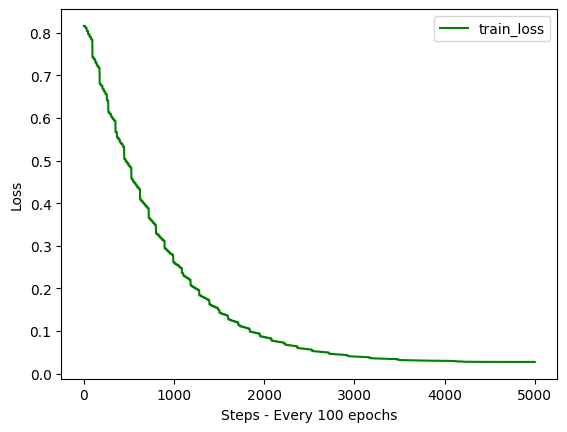

In [91]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [ ]:
#run inference

In [92]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [98]:
sentence = "Zeolites are materials"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Zeolites are materials!!!!!Govern!!!!!!!!!!!!!!! honored!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! slipping!!!!!!!!!article!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!cookie!!!!!!


In [99]:
sentence = "Through ML, synthesis conditions were"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 100)
print(enc.decode(y.squeeze().tolist()))

Through ML, synthesis conditions were!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!405!!!!!!erred!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
